In [93]:
#Libraries
import pandas as pd
import numpy as np
import random
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt

In [14]:
#Dataset Read
dataset_df = pd.read_csv('data/jm1.csv')

In [88]:
#Mutator Function:
def seen(dataset,parent_candidate):
    size = dataset.shape[0]
    candidate_1 = dataset.loc[random.randint(0,size-1)]
    while candidate_1.equals(parent_candidate):
        candidate_1 = dataset.loc[random.randint(0,size-1)]
    candidate_2 = dataset.loc[random.randint(0,size-1)]
    while candidate_2.equals(parent_candidate) or candidate_1.equals(candidate_2):
        candidate_2 = dataset.loc[random.randint(0,size-1)]
    return parent_candidate,candidate_1,candidate_2
    
def select_candiate(dataset):
    size = dataset.shape[0]
    parent_candidate = dataset.loc[random.randint(0,size-1)]
    return seen(dataset,parent_candidate)

def data_mutator(dataset, f,cr,size):
    new_candidate = pd.DataFrame()
    dataset_columns = dataset.columns.values
    response_attribute = dataset_columns[len(dataset_columns)-1]
    for i in range(size):
        parent_candidate, child_candidate_1, child_candidate_2 = select_candiate(dataset)
        for key,value in parent_candidate.items():
            if key != response_attribute:
                if isinstance(parent_candidate[key], bool):
                    new_candidate.loc[i,key] = parent_candidate[key] if cr < random.random() else not parent_candidate[key]
                elif isinstance(parent_candidate[key], str):
                    new_candidate.loc[i,key] = random.choice([parent_candidate[key],child_candidate_1[key],child_candidate_2[key]])
                elif isinstance(parent_candidate[key], list):
                    temp_lst = []
                    for i, each in enumerate(parent_candidate[key]):
                          temp_lst.append(parent_candidate[key][i] if cr < random.random() else
                                          int(parent_candidate[key][i] +
                                              f * (child_candidate_1[key][i] - child_candidate_2[key][i])))
                    new_candidate.loc[i,key] = temp_lst
                else:
                    new_candidate.loc[i,key] = parent_candidate[key] if cr < random.random() else (
                      parent_candidate[key] + f * (child_candidate_1[key] - child_candidate_2[key]))
            else:
                new_candidate[key] = parent_candidate[key]
    return new_candidate

In [89]:
new_data = data_mutator(dataset_df,0.2,0.75,10000)
print(new_data)

        loc  v(g)  ev(g)  iv(g)      n         v      l       d        i  \
0      56.6   9.6    7.6    3.0  143.0   794.720  0.040  27.900   28.020   
1      12.0  -3.8   -5.8    3.0   12.4  -124.416  0.166   6.466   30.654   
2      80.0   9.0    8.0    4.0    0.0  -221.234  0.000   0.000   -2.524   
3      49.6   4.8    0.4    5.6  183.4  1064.482  0.040  18.618   45.832   
4       2.2   1.8    1.0    1.8    2.8    43.020  0.256   4.000   10.750   
5      89.8   7.0    3.0    4.8  324.0  2066.284  0.072  28.250   75.426   
6      42.4   6.8    7.2    2.2  111.4   591.848  0.054  24.276   21.180   
7     119.4  23.4    1.6   15.8  322.4  1905.302  0.020  49.410   40.894   
8       9.0   1.0    1.0    1.0   24.8    97.670  0.190   5.824   20.300   
9     194.2  51.6   48.0   37.6  526.0  5422.818  0.012  86.000   70.018   
10     46.4   8.4    3.0    4.2   80.0   413.860  0.080  13.930   31.158   
11     89.2   8.6    1.0    1.0  246.2  1465.364  0.054  39.000   43.286   
12      6.0 

(array([    0.,     0.,     0.,     0.,     0., 10000.,     0.,     0.,
            0.,     0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

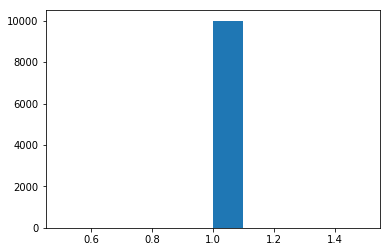

In [94]:
plt.hist(new_data.defects)